In [1]:
# Date to be predicted
obs_id = 1
date = '2022-11-10'
hour = 16

# Training configuration
k = 0.5
features = ['temperature', 'humidity', 'wind_spd', 'uv_idx', 'hour', 'year', 'month', 'day']
input_dim = len(features)
hidden_dim = 10

dir_data = '../data'
dir_ckpt = '../ckpt/1667819613'
path_ckpt = f'{dir_ckpt}/last_ckpt.bin'

token = 'YOUR AUTHORIZED TOKEN'

In [2]:
import sys
sys.path.append('../')

from suncapturer.networks import WaveNet
from suncapturer.utils import Requestor, standardize_time

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime


In [3]:
requestor = Requestor(token)

fcst_ = requestor.get_forecasts(obs_id, date, hour)

In [4]:
fcst_.shape

(72, 13)

In [5]:
fcst = fcst_.copy()
fcst['id'] = 0
fcst['fcst_time'] = pd.to_datetime(fcst['fcst_time'])
fcst['fcst_time'] = fcst['fcst_time'].dt.tz_convert(tz='Asia/Seoul')

fcst['time'] = pd.to_datetime(fcst['time'])
fcst['time'] = fcst['time'].dt.tz_convert(tz='Asia/Seoul')

fcst['fcst_time'] = fcst['fcst_time'].dt.round('60min')
fcst['forecast'] = ((fcst['time'] - fcst['fcst_time']).dt.total_seconds() / 60.0 / 60.0).astype('int')

start = 24 - hour
end = 48 - hour
fcst = fcst[(fcst['forecast'] > start) & (fcst['forecast'] <= end)].reset_index(drop=True)

# 1. Capacity
fcst['capacity'] = 472.39

# 3. Time-related features
fcst['hour']  = fcst['time'].dt.hour
fcst['year']  = fcst['time'].dt.year
fcst['month'] = fcst['time'].dt.month
fcst['day']   = fcst['time'].dt.day

In [6]:
with open(os.path.join(dir_ckpt, 'scaling_factor.pkl'), 'rb') as f:
    import pickle
    scaling_factor = pickle.load(f)
    
for col, factors in scaling_factor.items():
    fcst[col] = (fcst[col] - factors[0]) / (factors[1] - factors[0])
    
fcst

,fcst_time,time,temperature,humidity,dew_point,wind_dir,wind_spd,uv_idx,visibility,cloudiness,ceiling,precip_prob,precip_1h,id,forecast,capacity,hour,year,month,day
0,2022-11-09 09:00:00+09:00,2022-11-10 01:00:00+09:00,0.495145,0.938776,0.737588,0.897222,0.018957,0.000000,0.040503,0.99,0.587795,0.000000,0.0,0,0.304348,1.0,0.043478,1.0,0.909091,0.300000
1,2022-11-09 09:00:00+09:00,2022-11-10 02:00:00+09:00,0.495145,0.948980,0.730496,0.944444,0.018957,0.000000,0.040503,0.99,0.585356,0.000000,0.0,0,0.347826,1.0,0.086957,1.0,0.909091,0.300000
2,2022-11-09 09:00:00+09:00,2022-11-10 03:00:00+09:00,0.485436,0.959184,0.730496,0.983333,0.018957,0.000000,0.040503,0.98,0.585356,0.000000,0.0,0,0.391304,1.0,0.130435,1.0,0.909091,0.300000
3,2022-11-09 09:00:00+09:00,2022-11-10 04:00:00+09:00,0.485436,0.959184,0.723404,0.041667,0.018957,0.000000,0.040503,0.87,0.585356,0.000000,0.0,0,0.434783,1.0,0.173913,1.0,0.909091,0.300000
4,2022-11-09 09:00:00+09:00,2022-11-10 05:00:00+09:00,0.475728,0.948980,0.723404,0.108333,0.018957,0.000000,0.040503,0.75,0.124388,0.000000,0.0,0,0.478261,1.0,0.217391,1.0,0.909091,0.300000
5,2022-11-09 09:00:00+09:00,2022-11-10 06:00:00+09:00,0.466019,0.948980,0.709220,0.133333,0.018957,0.000000,0.040503,0.64,0.124388,0.000000,0.0,0,0.521739,1.0,0.260870,1.0,0.909091,0.300000
6,2022-11-09 09:00:00+09:00,2022-11-10 07:00:00+09:00,0.485436,0.948980,0.723404,0.122222,0.018957,0.000000,0.040503,0.57,0.731696,0.000000,0.0,0,0.565217,1.0,0.304348,1.0,0.909091,0.300000
7,2022-11-09 09:00:00+09:00,2022-11-10 08:00:00+09:00,0.504854,0.908163,0.730496,0.100000,0.036335,0.083333,0.040503,0.50,0.731696,0.000000,0.0,0,0.608696,1.0,0.347826,1.0,0.909091,0.300000
8,2022-11-09 09:00:00+09:00,2022-11-10 09:00:00+09:00,0.533980,0.826531,0.737588,0.075000,0.036335,0.166667,0.040503,0.43,0.731696,0.000000,0.0,0,0.652174,1.0,0.391304,1.0,0.909091,0.300000
9,2022-11-09 09:00:00+09:00,2022-11-10 10:00:00+09:00,0.563107,0.744898,0.737588,0.055556,0.036335,0.166667,0.040503,0.36,0.731696,0.000000,0.0,0,0.695652,1.0,0.434783,1.0,0.909091,0.300000


In [7]:
import torch

X_test = fcst.drop(['id', 'fcst_time', 'time'], axis=1)
X_test = X_test[features]
X_test = X_test.values
X_test = torch.from_numpy(X_test).float().unsqueeze(0)
X_test = torch.transpose(X_test, 1, 2)

model = WaveNet(input_dim, hidden_dim)
ckpt = torch.load(path_ckpt)
model.load_state_dict(ckpt['model_state_dict'])

with torch.no_grad():
    model.eval()

    out = model(X_test)

    bound = torch.zeros_like(out)
    bound[:, :, 0] = out[:, :, 0] - k * out[:, :, 1]
    bound[:, :, 1] = out[:, :, 0] + k * out[:, :, 1]
    bound = torch.nn.functional.relu(bound)
    bound = bound.detach().squeeze().numpy()
    bound = (472.39 * bound).astype(float)

submit = []
for row in bound:
    submit.append({'lower': row[0], 'upper': row[1]})

/home/dongjin/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


In [8]:
bound

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 15.37381172,  15.37381172],
       [ 65.74582672,  65.74582672],
       [154.70013428, 154.70013428],
       [217.35830688, 217.35830688],
       [259.82034302, 259.82034302],
       [262.5690918 , 262.5690918 ],
       [245.74450684, 245.74450684],
       [190.68051147, 190.68051147],
       [122.02714539, 122.02714539],
       [ 45.43349075,  45.43349075],
       [  5.42338037,   5.42338037],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

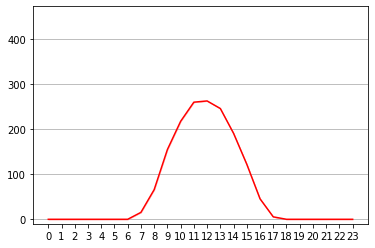

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(bound.mean(axis=1), 'r-')
plt.fill_between(x=np.arange(24), y1=bound[:, 0], y2=bound[:, 1], color='red', alpha=0.2)
plt.grid(axis='y')
plt.ylim(-10, 472.39)
plt.xticks(np.arange(24))
plt.show()

In [10]:
submit

[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 15.373811721801758, 'upper': 15.373811721801758},
 {'lower': 65.7458267211914, 'upper': 65.7458267211914},
 {'lower': 154.70013427734375, 'upper': 154.70013427734375},
 {'lower': 217.35830688476562, 'upper': 217.35830688476562},
 {'lower': 259.8203430175781, 'upper': 259.8203430175781},
 {'lower': 262.569091796875, 'upper': 262.569091796875},
 {'lower': 245.7445068359375, 'upper': 245.7445068359375},
 {'lower': 190.68051147460938, 'upper': 190.68051147460938},
 {'lower': 122.02714538574219, 'upper': 122.02714538574219},
 {'lower': 45.43349075317383, 'upper': 45.43349075317383},
 {'lower': 5.423380374908447, 'upper': 5.423380374908447},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'l

In [11]:
import requests
import json

success = requests.post(f'https://research-api.dershare.xyz/open-proc/cmpt-2022/bids', data=json.dumps(submit), headers={
                            'Authorization': f'Bearer {token}'
                        }).json()
print(success)

True


In [ ]:
requestor.